In [1]:
import sympy as sp
from sympt import *
import numpy as np
import matplotlib.pyplot as plt


from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor

import sys
import os
sys.path.append("/home/leander/GoogleDriveSync/PhD/Python/")
sys.path.append("/home/leander/GoogleDriveSync/PhD/Python/Researc_Projects/Spin Qubits and Skyrmions/")

from Elliptical_Well import EllipticalConfinement
from Packages.utils import apply_subs


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=18)     # fontsize |of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize


# Transparent background for figures but keep the legend background white but its text color black
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.edgecolor'] = 'none'
plt.rcParams['legend.framealpha'] = 0.8
plt.rcParams['legend.shadow'] = False
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'
# White spins, axis and ticks 
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'

In [2]:
H_conf = EllipticalConfinement()

normal_ordering = {
    H_conf.a_m * H_conf.a_p : H_conf.a_p * H_conf.a_m,
    H_conf.ad_m * H_conf.ad_p : H_conf.ad_p * H_conf.ad_m,
    H_conf.a_m * H_conf.ad_p : H_conf.ad_p * H_conf.a_m,
    H_conf.ad_m * H_conf.a_p : H_conf.a_p * H_conf.ad_m,
    H_conf.a_m * H_conf.ad_m : H_conf.ad_m * H_conf.a_m + 1,
    H_conf.a_p * H_conf.ad_p : H_conf.ad_p * H_conf.a_p + 1,
}

display_dict(normal_ordering)

H_conf.H

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

hbar*omega_x*(k_+*(1/2 + Dagger(a_+)*a_+) + k_-*(1/2 + Dagger(a_-)*a_-))

In [3]:
Spin = RDBasis('sigma', dim=2)
s0, sx, sy, sz = Spin.basis
spin_vector = sp.Matrix([sx, sy, sz])


kB = RDSymbol('k_B', real=True, positive=True)                 # External magnetic field
B = sp.Matrix([0, 0, kB])  # External magnetic field in the z-direction

H_Z = -sp.Rational(1, 2) * B.dot(spin_vector)  # Zeeman Hamiltonian
H_Z

-k_B*sigma_3/2

In [4]:
H0 = H_conf.H/(hbar * H_conf.omega_x) + H_Z  # Total Hamiltonian
H0

-k_B*sigma_3/2 + k_+*(1/2 + Dagger(a_+)*a_+) + k_-*(1/2 + Dagger(a_-)*a_-)

In [5]:
b = lambda x, ops: RDSymbol(f'b_{x}^{{({ops})}}', order=1, real=True)

def compute_b(order, alpha, x, y, lx):
    res = 0
    for n in range(order + 1):
        for m in range(order + 1):
            if n + m > order:
                continue
            upper_label = f'{x}^{n}{y}^{m}' if n != 0 and m != 0 else f'{x}^{n}' if n != 0 else f'{y}^{m}' if m != 0 else '0'
            res += b(alpha, upper_label) * x**n * y**m / (lx**(n + m))
    return res  
                
B_sk_x = compute_b(4, 'x', H_conf.x, H_conf.y, H_conf.lx)
B_sk_y = compute_b(4, 'y', H_conf.x, H_conf.y, H_conf.lx)
B_sk_z = compute_b(4, 'z', H_conf.x, H_conf.y, H_conf.lx)


kB0 = RDSymbol('k_{B_0}', real=True, positive=True)            # Magnetic field of the Skyrmion

B_sk = -kB0 * sp.Matrix([B_sk_x, B_sk_y, B_sk_z])   # kB0 is the strength of the Skyrmion magnetic field and points on the opposite direction of the external magnetic field

V1 = -sp.Rational(1, 2) * B_sk.dot(spin_vector)
V1 = V1.expand()

In [6]:
B_sk_x

b_x^{(0)} + b_x^{(x^1)}*x/l_x + b_x^{(x^1y^1)}*x*y/l_x**2 + b_x^{(x^1y^2)}*x*y**2/l_x**3 + b_x^{(x^1y^3)}*x*y**3/l_x**4 + b_x^{(x^2)}*x**2/l_x**2 + b_x^{(x^2y^1)}*x**2*y/l_x**3 + b_x^{(x^2y^2)}*x**2*y**2/l_x**4 + b_x^{(x^3)}*x**3/l_x**3 + b_x^{(x^3y^1)}*x**3*y/l_x**4 + b_x^{(x^4)}*x**4/l_x**4 + b_x^{(y^1)}*y/l_x + b_x^{(y^2)}*y**2/l_x**2 + b_x^{(y^3)}*y**3/l_x**3 + b_x^{(y^4)}*y**4/l_x**4

In [7]:
def apply_subs_to_dict(d, *dicts):
    for subs in dicts:
        d = {k: sp.factor_terms(v.subs(subs).simplify()) for k, v in d.items()}
    d = {k: v.factor() for k, v in d.items()}
    return d


Pp = Operator('P_+')
Pm = Operator('P_-')
Qp = Operator('Q_+')
Qm = Operator('Q_-')

subs_bosons_to_pq = {
    H_conf.ad_p : sp.Rational(1, 2) * (Qp + Pp),
    H_conf.a_p : sp.Rational(1, 2) * (Qp - Pp),
    H_conf.ad_m : sp.Rational(1, 2) * (Qm + Pm),
    H_conf.a_m : sp.Rational(1, 2) * (Qm - Pm),
}

subs_pq_to_bosons = {
    Qp : H_conf.ad_p + H_conf.a_p,
    Pp : H_conf.ad_p - H_conf.a_p,
    Qm : H_conf.ad_m + H_conf.a_m,
    Pm : H_conf.ad_m - H_conf.a_m,
}

normal_ordering_pq = {
    Pm * Pp : Pp * Pm,
    Qm * Qp : Qp * Qm,
    Pm * Qp : Qp * Pm,
    Qm * Pp : Pp * Qm,
    Qm * Pm : Pm * Qm + 2,
    Qp * Pp : Pp * Qp + 2,
}

x_0 = sp.symbols('x_0', real=True, positive=True)

kc_subs = {
    H_conf.kp**2 + 1 : sp.sqrt(H_conf.kc**2 + 4) * H_conf.kp,
    H_conf.km**2 + 1 : sp.sqrt(H_conf.kc**2 + 4) * H_conf.km,
    sp.sqrt(H_conf.km) : 1 / sp.sqrt(H_conf.kp),
    list(H_conf.subs_theta.keys())[0] : sp.pi / 4,
    (H_conf.kc**2 + 4)**(sp.Rational(1,4)) : 1/(sp.sqrt(2)*x_0),
}

circular_confinement_subs = apply_subs_to_dict(H_conf.inv_pos_mom_symbols, H_conf.inv_effective_lengths_subs, kc_subs, kc_subs)

pos_to_new_basis = apply_subs_to_dict(H_conf.pos_mom_to_new_basis_symbols, subs_bosons_to_pq, circular_confinement_subs, subs_pq_to_bosons)

display_dict(pos_to_new_basis)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [8]:
sigma_x, sigma_y, sigma_z = sp.symbols('sigma_x sigma_y sigma_z', commutative=False)
subs_paulis_to_symbols = {
    sx : sigma_x,
    sy : sigma_y,
    sz : sigma_z,
}

inv_subs_paulis_to_symbols = {
    sigma_x : sx,
    sigma_y : sy,
    sigma_z : sz,
}

V1_terms = [k * v.subs(inv_subs_paulis_to_symbols) for k,v in group_by_operators(apply_subs(V1, subs_paulis_to_symbols)).items()]
V1_terms_bosons = [apply_subs(v1_term.subs(pos_to_new_basis), normal_ordering) for v1_term in tqdm(V1_terms)]

 40%|████      | 6/15 [00:06<00:10,  1.21s/it]

KeyboardInterrupt: 

In [ ]:
b_sk_symbols = list(B_sk_x.atoms(RDSymbol)) + list(B_sk_y.atoms(RDSymbol)) + list(B_sk_z.atoms(RDSymbol))

In [ ]:
kE = sp.symbols('k_E', real=True)
H_Drive = (-1 / ( 2* kE**3 * H_conf.lx) * (H_conf.x).subs(H_conf.pos_mom_to_new_basis_symbols)).cancel().subs(circular_confinement_subs)
H_Drive

-(x_0*(Dagger(a_+) + a_+) - I*x_0*(-Dagger(a_-) + a_-))/(2*k_E**3)

In [ ]:
def compute_effective_frame(args):
    i, H1 = args
    #H1 = apply_subs(H1.subs(pos_to_new_basis).expand(), normal_ordering)
    #H1 = sp.Add(*[v*o for v,o in group_by_operators(H1).items()])
    Eff_frame = EffectiveFrame(H0 + H1, subspaces=[Spin], verbose=False)
    Eff_frame.solve(method='FD')
    Eff_frame.get_H(return_form='matrix')
    H_eff_2 = Eff_frame.H_corrections.get(2, 0)
    H_eff_1 = Eff_frame.H_corrections.get(1, 0)
    H_eff_Drive = Eff_frame.rotate(H_Drive, max_order=1, return_form='matrix')

    H_cross_terms = {}
    for j, term in enumerate(V1_terms_bosons):
        if i == j:
            continue
        H_cross_terms[j] = Eff_frame.rotate_corrections(term, max_order=2, return_form='matrix')

    return i, H_eff_1, H_eff_2, H_eff_Drive, H_cross_terms

In [ ]:
inputs = [(i, H1) for i, H1 in enumerate(V1_terms_bosons)]

import random
random.seed(42)  # Set a seed for reproducibility

random.shuffle(inputs)  # Shuffle the inputs to ensure random order of execution


# Use a multiprocessing Pool
with ProcessPoolExecutor(cpu_count()) as executor:
    results = list(tqdm(executor.map(compute_effective_frame, inputs), total=len(inputs)))

# Collect results
H_eff_1 = {}
H_eff_2 = {}
H_eff_Drive = {}
H_eff_cross = {}

for i, h1, h2, hd, h_cross in tqdm(results):
    H_eff_1[i] = h1
    H_eff_2[i] = h2
    H_eff_Drive[i] = hd
    H_eff_cross[i] = h_cross

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 345684.40it/s]


In [ ]:
project_into_qubit = {
    H_conf.a_m : 0,
    H_conf.ad_m : 0,
    H_conf.a_p : 0,
    H_conf.ad_p : 0,
}


In [ ]:
def project_into_qubit_term(args):
    i, term = args
    term = sp.Rational(1,2) * term[2]
    term = term.subs(project_into_qubit)
    return i, group_by_operators(Spin.project(term))



H_eff_cross_qubit = {}
for i, h_cross in tqdm(H_eff_cross.items()):
    H_eff_cross_qubit[i] = {}
    with ProcessPoolExecutor(cpu_count()) as executor:
        results = list(executor.map(project_into_qubit_term, h_cross.items()))
    for j, term in results:
        H_eff_cross_qubit[i][j] = term
        

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [01:53<00:00,  7.59s/it]


In [ ]:

gamma = sp.Symbol('gamma', real=True, positive=True)  # Gyromagnetic ratio
k0 = sp.symbols('k_0', real=True, positive=True)  # Characteristic wavevector


def simplify_terms(expr, *dict_subs):
    terms = expr.as_ordered_terms()
    simplified_terms = []
    for term in terms:
        term = apply_subs(term, *dict_subs).expand().simplify().factor()
        n, d = term.as_numer_denom()
        n = sp.factor(n)
        term = n / d if d != 1 else n
        simplified_terms.append(term)


    same_denom = {}
    for term in simplified_terms:
        n, d = term.as_numer_denom()
        d = tuple(list(map(lambda x:sp.Abs(x), d.expand().as_ordered_terms())))
        if d not in same_denom:
            same_denom[d] = []
        same_denom[d].append(term)
    
    simplified_terms = []
    for n, terms in same_denom.items():
        simplified_terms.append(sp.Add(*terms).simplify())

    return sp.Add(*simplified_terms)

def simplify_correction_terms(corrections):
    simplified_corrections = []
    same_denom = {}
    for term in corrections.as_ordered_terms():
        n, d = term.as_numer_denom()
        d = tuple(d.as_ordered_terms())
        if d not in same_denom:
            same_denom[d] = []
        same_denom[d].append(term)

    for d, terms in same_denom.items():
        simplified_corrections.append(sp.Add(*terms).simplify())

    return sp.Add(*simplified_corrections)


subs_ks = {
    kB : gamma * sp.Abs(H_conf.kc),
    H_conf.kp * H_conf.km : 1,
}

subs_kp_km = {
    H_conf.kp : sp.Rational(1, 2) * (k0 + sp.Abs(H_conf.kc)),
    H_conf.km : sp.Rational(1, 2) * (k0 - sp.Abs(H_conf.kc)),
}

subs_k0 = {
    k0 : sp.sqrt(H_conf.kc**2 + 4)
}

subs_inv = {
    sp.sqrt(H_conf.kc**2 + 4) : k0,
    gamma * sp.Abs(H_conf.kc) : kB,
    gamma**2 * H_conf.kc**2 : kB**2,
    k0**2 + 2 *k0 * sp.Abs(H_conf.kc) + H_conf.kc**2 : H_conf.kp**2,
}

subs_ks_inv = {
    k0 * sp.Abs(H_conf.kc) : H_conf.kp**2 - H_conf.km**2,
    H_conf.kc**2 : H_conf.kp**2 + H_conf.km**2 - 2
}


simplification_rules = {
        n * H_conf.kp**2 + H_conf.km**2 : H_conf.kc**2 + 2 + (n - 1) * H_conf.kp**2 for n in range(1, 10)
}

simplification_rules.update({
    H_conf.kp**2 + n * H_conf.km**2 : H_conf.kc**2 + 2 + (n - 1) * H_conf.km**2 for n in range(1, 10)
})

simplification_rules.update({
    n * H_conf.kp**2 + n * H_conf.km**2 : n * H_conf.kc**2 + 2 * n for n in range(1, 10)
})

#simplification_rules.update({kB : gamma * sp.Abs(H_conf.kc)})


H_eff_2 = {i : H_eff_2[i] for i in range(len(V1_terms))}

H_eff_2_corrections = []

for i in range(len(V1_terms)):
    h = H_eff_2[i]
    if not np.any(h):
        continue
    h = apply_subs(h, project_into_qubit)
    qubit_freq = (h[0, 0] - h[1, 1]).expand()
    if not np.any(qubit_freq):
        continue
    
    delta = simplify_correction_terms(apply_subs(simplify_terms(simplify_terms(qubit_freq), subs_kp_km, subs_ks, subs_k0, subs_inv, subs_ks_inv), simplification_rules))
    H_eff_2_corrections.append(delta)
    #display_dict({V1_terms[i]: H_eff_2_corrections[-1]})



H_eff_1 = {i : H_eff_1[i] for i in range(len(V1_terms))}
H_eff_1_corrections = []

for i, h in H_eff_1.items():
    if not np.any(h):
        continue
    h = apply_subs(h, project_into_qubit)
    qubit_freq = (h[0, 0] - h[1, 1]).expand()
    if not np.any(qubit_freq):
        continue

    delta = simplify_terms(simplify_terms(qubit_freq), subs_kp_km, subs_ks, subs_k0, subs_inv, subs_ks_inv)
    H_eff_1_corrections.append(delta)

    #display_dict({V1_terms[i]: sp.factor_terms(delta)})

In [ ]:
def collect_same_factors(expr):
    terms = expr.as_ordered_terms()
    simplified_terms = {}
    simplified_dict = {}
    for term in terms:
        factors = term.as_ordered_factors()
        key_factor = factors[-1]
        if key_factor not in simplified_dict:
            simplified_dict[key_factor] = []

        simplified_dict[key_factor].append(sp.Mul(*factors[:-1], evaluate=False))

    for key_factor, terms in simplified_dict.items():
        simplified_terms[key_factor] = sp.factor_terms(sp.Add(*terms))

    return simplified_terms

def collect_same_denom(expr):
    same_denom = {}
    for term in expr.as_ordered_terms():
        n, d = term.as_numer_denom()
        d = sp.factor_terms(d)
        coeff, d = d.as_coeff_Mul()
        if d not in same_denom:
            same_denom[d] = []
        same_denom[d].append(n / coeff)

    for d, terms in same_denom.items():
        same_denom[d] = sp.factor_terms(sp.Add(*terms))

    return same_denom

def invert_dict(d):
    new_dict = {}
    for k, v in d.items():
        factors = v.as_ordered_factors()
        key_factor = factors[-1]
        if key_factor not in new_dict:
            new_dict[key_factor] = []
        new_dict[key_factor].append(sp.Mul(*factors[:-1], evaluate=False) / k)

    for key_factor, terms in new_dict.items():
        new_dict[key_factor] = sp.factor_terms(sp.Add(*terms)).simplify()
    return new_dict

In [ ]:
def subs_in_keys(dict, *dicts):
    for subs in dicts:
        dict = {sp.factor_terms(k.expand()).subs(subs): v for k, v in dict.items()}
    return dict
import re 

B_k = lambda x, k: sp.Matrix([b(x, f'x^{k - n}y^{n}' if n != 0 and k-n != 0 else f'x^{k}' if n == 0 else f'y^{n}' if n != 0 else '0')  for n in range(k + 1)])

W = lambda w: sp.diag(*w)

W_4 = Operator('W^{(4)}')
V_4 = Operator('V^{(4)}')
W_2 = Operator('W^{(2)}')
V_2 = Operator('V^{(2)}')
W_3 = Operator('W^{(3)}')

B_k_op = lambda x, k: Operator(f'B_{{{x}}}^{{({k})}}')

subs_bk_symbols = {
    (B_k('x', 4).T * W([4,1,0,1,4]) * B_k('x', 4))[0] : sp.transpose(B_k_op('x', 4)) * W_4 * B_k_op('x', 4),
    (B_k('y', 4).T * W([4,1,0,1,4]) * B_k('y', 4))[0] : sp.transpose(B_k_op('y', 4)) * W_4 * B_k_op('y', 4),
    (B_k('y', 4).T * B_k('y', 4))[0] : sp.transpose(B_k_op('y', 4)) * B_k_op('y', 4),
    (B_k('x', 4).T * B_k('x', 4))[0] : sp.transpose(B_k_op('x', 4)) * B_k_op('x', 4),
    (B_k('x', 2).T * B_k('x', 2))[0] : sp.transpose(B_k_op('x', 2)) * B_k_op('x', 2),
    (B_k('y', 2).T * B_k('y', 2))[0] : sp.transpose(B_k_op('y', 2)) * B_k_op('y', 2),
    (B_k('x', 4).T * x_0**4 * W([144, 36, 0, 36, 144]) * B_k('x', 4))[0] : sp.transpose(B_k_op('x', 4)) * W_4 * B_k_op('x', 4) * 36 * x_0**4,
    (B_k('y', 4).T * x_0**4 * W([144, 36, 0, 36, 144]) * B_k('y', 4))[0]: sp.transpose(B_k_op('y', 4)) * W_4 * B_k_op('y', 4) * 36 * x_0**4,
    (B_k('x', 4).T * W([9, 0, 1, 0, 9]) * B_k('x', 4))[0] : sp.transpose(B_k_op('x', 4)) * V_4 * B_k_op('x', 4),
    (B_k('y', 4).T * W([9, 0, 1, 0, 9]) * B_k('y', 4))[0] : sp.transpose(B_k_op('y', 4)) * V_4 * B_k_op('y', 4),
    (B_k('x', 4).T * x_0**4 * W([144, 0, 16, 0, 144]) * B_k('x', 4))[0] : sp.transpose(B_k_op('x', 4)) * V_4 * B_k_op('x', 4) * 16 * x_0**4,
    (B_k('y', 4).T * x_0**4 * W([144, 0, 16, 0, 144]) * B_k('y', 4))[0] : sp.transpose(B_k_op('y', 4)) * V_4 * B_k_op('y', 4) * 16 * x_0**4,
    (B_k('x', 2).T * W([1, 0, 1]) * B_k('x', 2))[0] : sp.transpose(B_k_op('x', 2)) * W_2 * B_k_op('x', 2),
    (B_k('y', 2).T * W([1, 0, 1]) * B_k('y', 2))[0] : sp.transpose(B_k_op('y', 2)) * W_2 * B_k_op('y', 2),
    (B_k('x', 3).T * W([9, 1, 1, 9]) * B_k('x', 3))[0] : sp.transpose(B_k_op('x', 3)) * W_3 * B_k_op('x', 3),
    (B_k('y', 3).T * W([9, 1, 1, 9]) * B_k('y', 3))[0] : sp.transpose(B_k_op('y', 3)) * W_3 * B_k_op('y', 3),
    (B_k('x', 3).T * B_k('x', 3))[0] : sp.transpose(B_k_op('x', 3)) * B_k_op('x', 3),
    (B_k('y', 3).T * B_k('y', 3) )[0] : sp.transpose(B_k_op('y', 3)) * B_k_op('y', 3),
    ((B_k('x', 1).T * B_k('x', 1))[0]/2).expand() : sp.transpose(B_k_op('x', 1)) * B_k_op('x', 1) * sp.Rational(1, 2),
    ((B_k('y', 1).T * B_k('y', 1))[0]/2).expand() : sp.transpose(B_k_op('y', 1)) * B_k_op('y', 1) * sp.Rational(1, 2),
    (B_k('x', 3).T * 2 * x_0**4 * W([9, 1, 1, 9]) * B_k('x', 3))[0] : sp.transpose(B_k_op('x', 3)) * W_3 * B_k_op('x', 3) * 2 * x_0**4,
    (B_k('y', 3).T * 2 * x_0**4 *W([9, 1, 1, 9]) * B_k('y', 3))[0] : sp.transpose(B_k_op('y', 3)) * W_3 * B_k_op('y', 3) * 2 * x_0**4,
    (B_k('x', 2).T * 2 * x_0**4 * W([1, 0, 1]) * B_k('x', 2))[0] : sp.transpose(B_k_op('x', 2)) * V_2 * B_k_op('x', 2) * 2 * x_0**4,
    (B_k('y', 2).T * 2 * x_0**4 * W([1, 0, 1]) * B_k('y', 2))[0] : sp.transpose(B_k_op('y', 2)) * V_2 *B_k_op('y', 2) * 2 * x_0**4,
    (B_k('x', 4).T * 8 * x_0**8 * W([9, 0, 1, 0, 9]) * B_k('x', 4))[0] : sp.transpose(B_k_op('x', 4)) * V_4 * B_k_op('x', 4) * 8 * x_0**8,
    (B_k('y', 4).T * 8 * x_0**8 * W([9, 0, 1, 0, 9]) * B_k('y', 4))[0] : sp.transpose(B_k_op('y', 4)) * V_4 * B_k_op('y', 4) * 8 * x_0**8,
}   


subs_simplification_drive = {
   -H_conf.kp**2 + H_conf.km**2 : (-H_conf.kp**2 + H_conf.km**2).subs(subs_kp_km).expand(),
   H_conf.kp**2 + H_conf.km**2 : (H_conf.kp**2 + H_conf.km**2).subs(subs_kp_km).expand(),
}

subs_simplification_drive.update({
    (- H_conf.kp * (kB**2 - H_conf.km**2) - H_conf.km * (kB**2 - H_conf.kp**2)): (- H_conf.kp * (kB**2 - H_conf.km**2) - H_conf.km * (kB**2 - H_conf.kp**2)).expand().subs(H_conf.kp*H_conf.km, 1).collect(-kB**2).collect(H_conf.kp + H_conf.km).subs(H_conf.kp + H_conf.km, k0).subs(subs_simplification_drive).expand().collect(k0)
})



In [ ]:
B_tilde, B_0_tilde = sp.symbols(r'\tilde{B} \tilde{B_0}', real=True, positive=True)
Omega_0 = sp.symbols(r'\Omega_0', real=True, positive=True) 
omega_c = sp.symbols(r'\omega_c', real=True)


ks_to_freq = {
    k0 : 2 * Omega_0 / H_conf.omega_x,
    kB0 : B_0_tilde / H_conf.omega_x,
    kB : B_tilde / H_conf.omega_x,
}

In [ ]:
def apply_subs_to_dict_num_denom(d_, *dicts, collect=[]):
    for subs in dicts:
        di = {}
        for k ,v in d_.items():
            n, d = v.as_numer_denom()
            n = apply_subs(n, subs).simplify()
            d = apply_subs(d, subs).simplify().factor()
            di[k] = n / d if d != 1 else n
        d_ = di
    di = {}
    for k, v in d_.items():
        n, d = v.as_numer_denom()
        n = n.factor()
        d = d.expand()
        if len(collect) > 0:
            for c in collect:
                n = n.collect(c)
                d = d.collect(c).simplify().factor()
        di[k] = n / d if d != 1 else n
    return di

def series_dict(dict, x, x0, n):
    new_dict = {}
    for k, v in dict.items():
        new_dict[k] = sp.series(v, x, x0, n).removeO().expand()
    return new_dict

def sum_dict(dict):
    result = 0
    for k, v in dict.items():
        result += v * k
    return result

def simplify_term_by_term(expr, *dicts):
    terms = expr.as_ordered_terms()
    result = 0
    for term in terms:
        term = apply_subs(apply_subs(term, *dicts).simplify(), *dicts).simplify()
        result += term

    return result

In [ ]:
def expand_dict(dict, *subs_dict):
    return {k: apply_subs(v.simplify(),*subs_dict).simplify() for k, v in dict.items()}


qubit_corrections = apply_subs_to_dict(expand_dict(invert_dict(collect_same_denom(apply_subs(sp.series(sp.Add(*H_eff_2_corrections).expand(), kB,0,2).removeO().expand(), {x_0: 1/sp.sqrt(2 * k0)}))), {H_conf.kp*H_conf.km: 1}), {H_conf.kc**2: k0**2 - 4}, subs_kp_km, {k0**2: H_conf.kc**2 + 4}, {kB: gamma * sp.Abs(H_conf.kc)})

display_dict(qubit_corrections)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
qubit_corrections_cross_terms = {}
for i, h_cross in H_eff_cross_qubit.items():
    qubit_corrections_cross_terms[i] = []
    for j, term in h_cross.items():
        if not np.any(term):
            continue
        qubit_corrections_cross_terms[i].append(term.get(sz, 0))

qubit_corrections_ct = sp.Add(*[sp.Add(*v) for v in qubit_corrections_cross_terms.values()])

In [ ]:
qubit_corrections_ct = apply_subs_to_dict(expand_dict(invert_dict(collect_same_denom(apply_subs(sp.series(qubit_corrections_ct.expand(), kB,0,2).removeO().expand(), {x_0: 1/sp.sqrt(2 * k0)}))), {H_conf.kp*H_conf.km: 1}), {H_conf.kc**2: k0**2 - 4}, subs_kp_km, {k0**2: H_conf.kc**2 + 4}, {kB: gamma * sp.Abs(H_conf.kc)})

display_dict(qubit_corrections_ct)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
qubit_corrections_dict_H1 = {}
for h1_correction in H_eff_1_corrections:
    for b_sk_symbol in b_sk_symbols:
        coeff = h1_correction.coeff(b_sk_symbol)
        if coeff != 0:
            qubit_corrections_dict_H1[b_sk_symbol] = coeff.subs({x_0: 1/sp.sqrt(2 * k0)})

In [ ]:
import dill as pickle

with open('taylor_series.pkl', 'rb') as f:
    taylor_series = pickle.load(f)

In [ ]:
bx_taylor_series = taylor_series['Bx']
by_taylor_series = taylor_series['By']
bz_taylor_series = taylor_series['Bz']

In [ ]:
L = 1
R = np.linspace(0.01, 0.5, 100)
Dr = np.linspace(0.01, 2, 100)

Dz = 150 / 60
B0 = 1

Bx_values = {k: [f(R, L, 0, 0, Dz, B0) + f(R + 0.2, L, 2, 0, Dz, B0) + f(R - 0.15, L, -2, 0, Dz, B0) for f in b_f] for k, b_f in bx_taylor_series.items()}
By_values = {k: [f(R, L, 0, 0, Dz, B0) + f(R + 0.2, L, 2, 0, Dz, B0) + f(R - 0.15, L, -2, 0, Dz, B0) for f in b_f] for k, b_f in by_taylor_series.items()}
Bz_values = {k: [f(R, L, 0, 0, Dz, B0) + f(R + 0.2, L, 2, 0, Dz, B0) + f(R - 0.15, L, -2, 0, Dz, B0) for f in b_f] for k, b_f in bz_taylor_series.items()}

In [ ]:
symbols_bk_subs = [{} for r in range(100)]
for k, bx_v in Bx_values.items():
    for n, bx in enumerate(bx_v):
        m = k - n
        upper_label = f'x^{n}y^{m}' if n != 0 and m != 0 else f'x^{n}' if n != 0 else f'y^{m}' if m != 0 else '0'
        for i, bx_r in enumerate(bx):
            symbols_bk_subs[i][b('x', upper_label)] = bx_r

for k, by_v in By_values.items():
    for n, by in enumerate(by_v):
        m = k - n
        upper_label = f'x^{n}y^{m}' if n != 0 and m != 0 else f'x^{n}' if n != 0 else f'y^{m}' if m != 0 else '0'
        for i, by_r in enumerate(by):
            symbols_bk_subs[i][b('y', upper_label)] = by_r

for k, bz_v in Bz_values.items():
    for n, bz in enumerate(bz_v):
        m = k - n
        upper_label = f'x^{n}y^{m}' if n != 0 and m != 0 else f'x^{n}' if n != 0 else f'y^{m}' if m != 0 else '0'
        for i, bz_r in enumerate(bz):
            symbols_bk_subs[i][b('z', upper_label)] = bz_r


<IPython.core.display.Math object>

-0.004750000000000001 -0.02375


<IPython.core.display.Math object>

3.4807296447016617e-06 0.0005751446346626645


<IPython.core.display.Math object>

4.3293193069306937e-07 6.4303125e-05


<IPython.core.display.Math object>

4.6615296916471497e-08 3.64416710667804e-06


<IPython.core.display.Math object>

1.435944572896726e-07 1.917148782208883e-05


<IPython.core.display.Math object>

3.1438676745522555e-07 2.394e-05


<IPython.core.display.Math object>

8.037102673757477e-08 9.64546875e-06


<IPython.core.display.Math object>

-0.001175322333594746 -0.004715705


<IPython.core.display.Math object>

-0.00029058330481213746 -0.0009208492499999999


<IPython.core.display.Math object>

0.019000000000000003 0.095


<IPython.core.display.Math object>

0.009452853306994899 0.042485291572496


<IPython.core.display.Math object>

0.004702970297029704 0.019


<IPython.core.display.Math object>

0.014108910891089108 0.056999999999999995


<IPython.core.display.Math object>

0.009452853306994899 0.042485291572496


<IPython.core.display.Math object>

0.014108910891089108 0.056999999999999995


<IPython.core.display.Math object>

-0.0023632133267487247 -0.010621322893124


<IPython.core.display.Math object>

-0.001175742574257426 -0.00475


<IPython.core.display.Math object>

4.3293193069306937e-07 6.4303125e-05


<IPython.core.display.Math object>

1.2342218747600996e-05 0.000365068918711695


<IPython.core.display.Math object>

1.0108307856511888e-05 0.00013944391871169502


<IPython.core.display.Math object>

4.9615105320822584e-05 0.0016326378374233901


<IPython.core.display.Math object>

4.063489467917743e-05 0.0006236121625766099


<IPython.core.display.Math object>

7.179722864483619e-08 9.5857439110444e-06


<IPython.core.display.Math object>

6.140483331784973e-06 0.00016326378374233898


<IPython.core.display.Math object>

5.0290711236605724e-06 6.236121625766098e-05


<IPython.core.display.Math object>

1.3984589074941454e-07 1.0932501320034122e-05


<IPython.core.display.Math object>

1.7839896012231407e-06 2.6180565114332818e-05


<IPython.core.display.Math object>

1.906391826787502e-06 3.5353525794758087e-05


<IPython.core.display.Math object>

3.1438676745522555e-07 2.394e-05


<IPython.core.display.Math object>

8.037102673757477e-08 9.64546875e-06


<IPython.core.display.Math object>

4.582506960742945e-06 0.00010952067561350849


<IPython.core.display.Math object>

3.7530846001900574e-06 4.183317561350851e-05


<IPython.core.display.Math object>

7.86191601057723e-06 9.895587471748801e-05


<IPython.core.display.Math object>

8.685164011126e-06 0.000155955874717488


<IPython.core.display.Math object>

-0.000584535638661479 -0.002093590198109458


<IPython.core.display.Math object>

4.202406626801294e-07 3.4294999999999996e-05


<IPython.core.display.Math object>

-0.0008717499144364122 -0.0027625477499999994


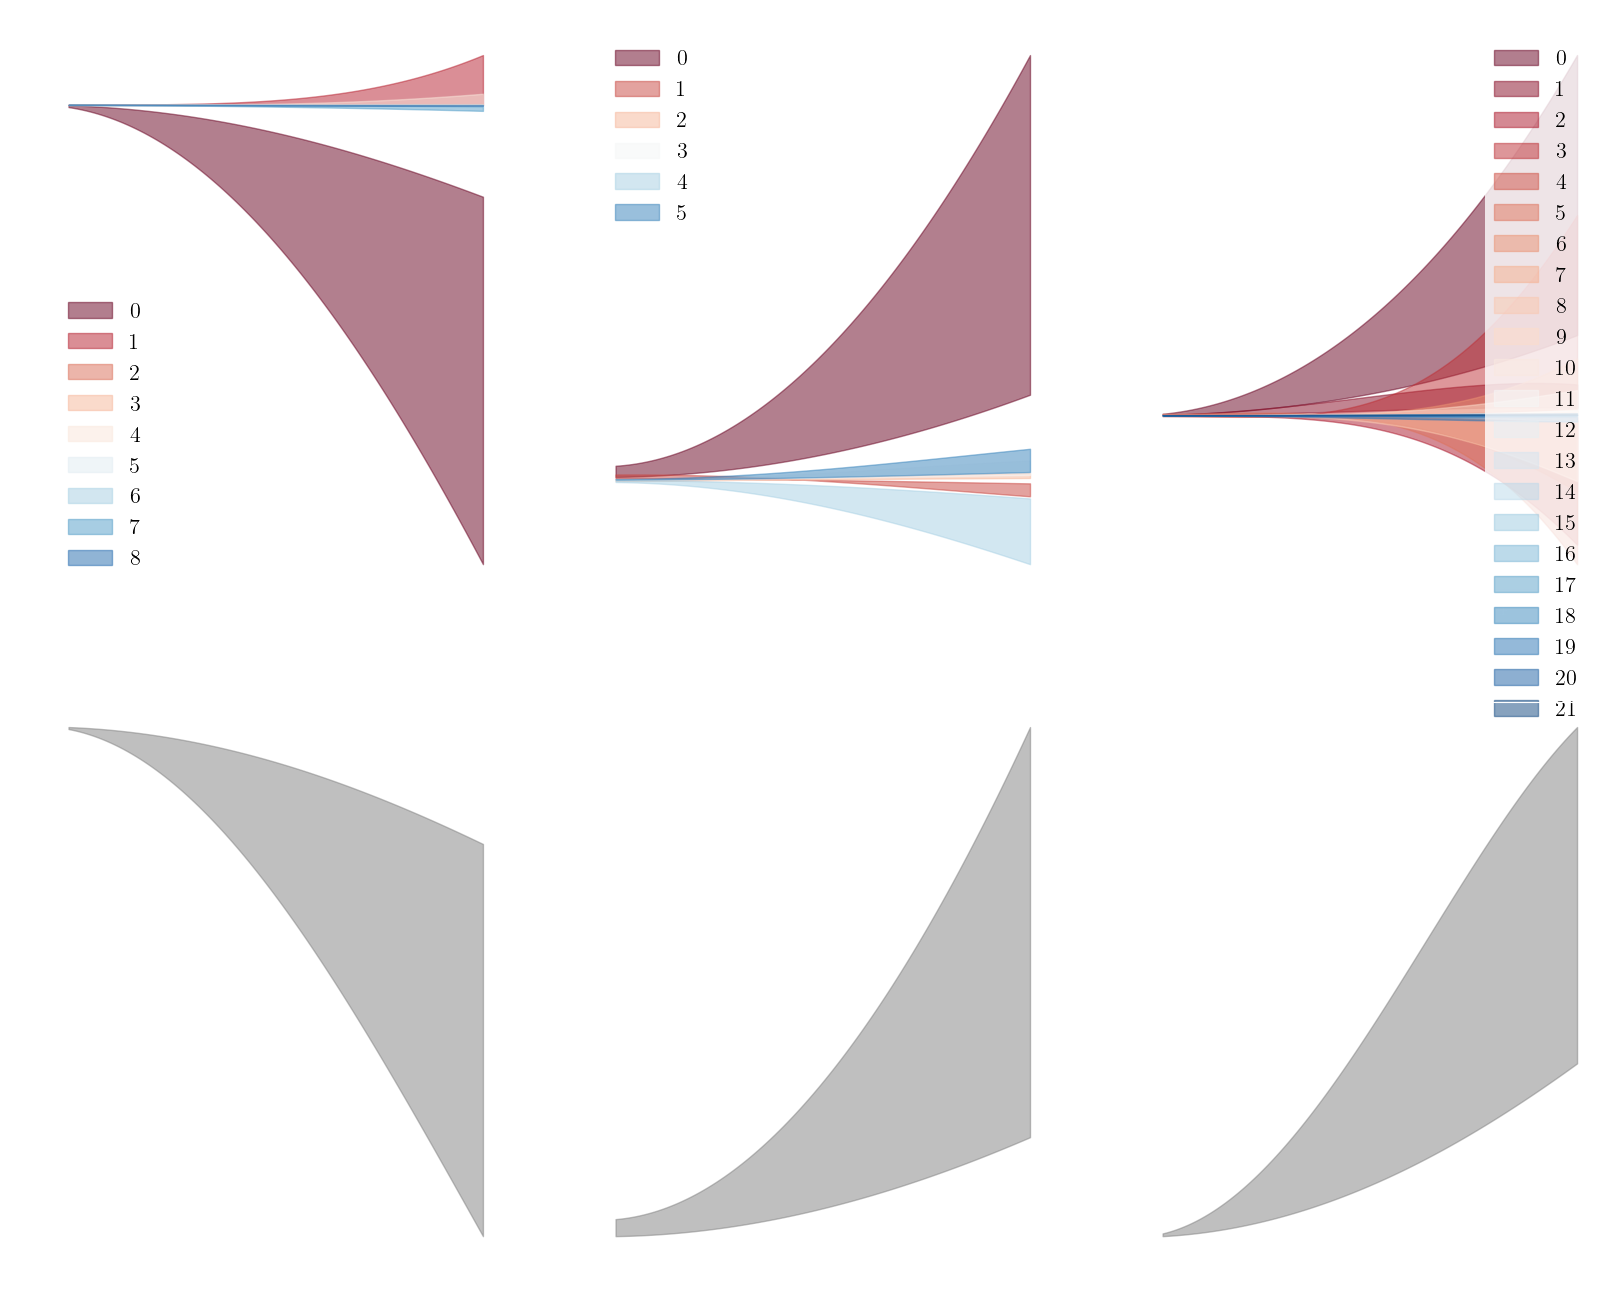

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(20, 16), sharey=False)

ax = axs[0]

cmap = plt.get_cmap('RdBu')

kc_values = np.array([0.2, 1])

total_freq = [np.zeros_like(R), np.zeros_like(R)]
for i, (k, v) in enumerate(qubit_corrections.items()):
   
    v = v.subs(kB0, gamma * sp.Abs(H_conf.kc) / 2)
    v = v.subs(gamma, 0.19)
    v_f = sp.lambdify(H_conf.kc, v, modules='numpy')
    min_kc, max_kc = v_f(kc_values)
    
    k_vals = []
    for r, subs in enumerate(symbols_bk_subs):
        k_vals.append(k.subs(subs))
    try:    
        k_vals = np.array(k_vals, dtype=float)
        if not np.any(k_vals):
            continue
        display_dict({i:k})
        print(min_kc, max_kc)
        total_freq[0] += k_vals * min_kc
        total_freq[1] += k_vals * max_kc
        ax[0].fill_between(R, k_vals * min_kc, k_vals * max_kc, color=cmap(i / len(qubit_corrections)), alpha=0.5, label=f'{i}')
    except Exception as e:
        continue
axs[1][0].fill_between(R, total_freq[0], total_freq[1], color='gray', alpha=0.5, label='Total Frequency Range')

total_freq = [np.zeros_like(R), np.zeros_like(R)]
for i, (k, v) in enumerate(qubit_corrections_dict_H1.items()):
    if v != 1:
        v = v.subs(k0, sp.sqrt(H_conf.kc**2 + 4))
        v = v.subs(kB0, gamma * sp.Abs(H_conf.kc) / 2)
        v = v.subs(gamma, 0.19)
        v_f = sp.lambdify(H_conf.kc, v, modules='numpy')
        min_kc, max_kc = v_f(kc_values)
    else:
        min_kc, max_kc = 1, 1

    k_vals = []
    for r, subs in enumerate(symbols_bk_subs):
        k_vals.append(k.subs(subs))
    k_vals = np.array(k_vals, dtype=float)
    if not np.any(k_vals):
        continue
    try:
        display_dict({i:k})
        print(min_kc, max_kc)
        ax[1].fill_between(R, k_vals * min_kc, k_vals * max_kc, color=cmap(i / len(qubit_corrections_dict_H1)), alpha=0.5, label=f'{i}')
        total_freq[0] += k_vals * min_kc
        total_freq[1] += k_vals * max_kc
    except Exception as e:
        continue

axs[1][1].fill_between(R, total_freq[0], total_freq[1], color='gray', alpha=0.5, label='Total Frequency Range')

total_freq = [np.zeros_like(R), np.zeros_like(R)]
for i, (k, v) in enumerate(qubit_corrections_ct.items()):
    if v != 1:
        v = v.subs(k0, sp.sqrt(H_conf.kc**2 + 4))
        v = v.subs(kB0, gamma * sp.Abs(H_conf.kc) / 2)
        v = v.subs(gamma, 0.19)
        v_f = sp.lambdify(H_conf.kc, v, modules='numpy')
        min_kc, max_kc = v_f(kc_values)
    else:
        min_kc, max_kc = 1, 1

    k_vals = []
    for r, subs in enumerate(symbols_bk_subs):
        k_vals.append(k.subs(subs))
    k_vals = np.array(k_vals, dtype=float)
    if not np.any(k_vals):
        continue
    try:
        display_dict({i:k})
        print(min_kc, max_kc)
        total_freq[0] += k_vals * min_kc
        total_freq[1] += k_vals * max_kc
        ax[2].fill_between(R, k_vals * min_kc, k_vals * max_kc, color=cmap(i / len(qubit_corrections_ct)), alpha=0.5, label=f'{i}')
    except Exception as e:
        continue

axs[1][2].fill_between(R, total_freq[0], total_freq[1], color='gray', alpha=0.5, label='Total Frequency Range')    

ax[0].legend()
ax[1].legend()
ax[2].legend()

In [ ]:
qubit_corrections = subs_in_keys(apply_subs_to_dict(series_dict(apply_subs_to_dict(subs_in_keys(invert_dict(collect_same_denom(sp.Add(*H_eff_2_corrections))), subs_bk_symbols, {x_0: 1/sp.sqrt(2 * k0)}), {x_0: 1/sp.sqrt(2 * k0)}, subs_kp_km, {H_conf.kc**2: k0**2 - 4}), kB, 0, 2),{H_conf.kc**2: k0**2 - 4}, ks_to_freq), ks_to_freq)

display_dict(qubit_corrections)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
sp.factor_terms(apply_subs(sp.factor_terms(sp.Add(*H_eff_1_corrections))))

k_{B_0}*(b_z^{(0)} + 2*b_z^{(x^2)}*x_0**2 + 4*b_z^{(x^2y^2)}*x_0**4 + 12*b_z^{(x^4)}*x_0**4 + 2*b_z^{(y^2)}*x_0**2 + 12*b_z^{(y^4)}*x_0**4)

In [ ]:
1/0

ZeroDivisionError: division by zero

In [ ]:
H_eff_Drive = {i : H_eff_Drive[i] for i in range(len(V1_terms))}

H_eff_Drive_Ex = []
H_eff_Drive_Ey = []
H_eff_Drive_Ez = []

H_eff_Drive_corrections = []

for i in range(len(V1_terms)):
    h = H_eff_Drive[i]
    h = apply_subs(h, project_into_qubit)
    if not np.any(h):
        continue
    h = group_by_operators(Spin.project(h))
    E_z = h.get(sz, 0)
    E_x = h[sx]
    E_y = h[sy]

    delta = simplify_correction_terms(apply_subs(simplify_terms(simplify_terms(E_z), subs_ks, subs_k0, subs_inv, subs_ks_inv), simplification_rules)).simplify() if E_z else 0
    E_x = simplify_correction_terms(apply_subs(simplify_terms(simplify_terms(E_x), subs_ks, subs_k0, subs_inv, subs_ks_inv), simplification_rules)).simplify()
    E_y = simplify_correction_terms(apply_subs(simplify_terms(simplify_terms(E_y), subs_ks, subs_k0, subs_inv, subs_ks_inv), simplification_rules)).simplify()
    H_eff_Drive_corrections.append((E_x, E_y, delta))
    
    H_eff_Drive_Ex.append(E_x)
    H_eff_Drive_Ey.append(E_y)
    H_eff_Drive_Ez.append(delta)
    display_dict({V1_terms[i]: H_eff_Drive_corrections[-1]})


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
subs_simplification_drive = {
   -H_conf.kp**2 + H_conf.km**2 : (-H_conf.kp**2 + H_conf.km**2).subs(subs_kp_km).expand(),
   (- H_conf.kp * (kB**2 - H_conf.km**2) - H_conf.km * (kB**2 - H_conf.kp**2)): (- H_conf.kp * (kB**2 - H_conf.km**2) - H_conf.km * (kB**2 - H_conf.kp**2)).expand().subs(H_conf.kp*H_conf.km, 1).collect(-kB**2).collect(H_conf.kp + H_conf.km).subs(H_conf.kp + H_conf.km, k0).subs(subs_simplification_drive).expand().collect(k0)
}

display_dict(subs_simplification_drive)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:


omega_c = sp.symbols(r'\omega_c', real=True, positive=True)  # Characteristic frequency

ks_to_freq.update({H_conf.kc: omega_c / H_conf.omega_x})


E_x = sp.factor_terms(simplify_term_by_term(simplify_term_by_term(sp.series(sp.Add(*H_eff_Drive_Ex), kB, 0, 2).removeO().subs({x_0: 1/sp.sqrt(2 * k0)}).expand().collect(b_sk_symbols), {H_conf.kp*H_conf.km: 1}).subs({
    H_conf.kp + H_conf.km: k0,
    H_conf.kp**2 - H_conf.km**2: (H_conf.kp - H_conf.km) * k0
}).collect(H_conf.kp - H_conf.km).subs(subs_kp_km).expand().collect(b_sk_symbols), subs_ks))
E_x

k_{B_0}*(b_x^{(x^1)} + b_x^{(x^1y^2)}/k_0 + 3*b_x^{(x^3)}/k_0 - b_y^{(x^2y^1)}*gamma*k_c**2/k_0 - b_y^{(y^1)}*gamma*k_c**2 - 3*b_y^{(y^3)}*gamma*k_c**2/k_0)/(4*k_E**3)

In [ ]:
E_y = sp.factor_terms(simplify_term_by_term(simplify_term_by_term(sp.series(sp.Add(*H_eff_Drive_Ey), kB, 0, 2).removeO().subs({x_0: 1/sp.sqrt(2 * k0)}).expand().collect(b_sk_symbols), {H_conf.kp*H_conf.km: 1}).subs({
    H_conf.kp + H_conf.km: k0,
    H_conf.kp**2 - H_conf.km**2: (H_conf.kp - H_conf.km) * k0
}).collect(H_conf.kp - H_conf.km).subs(subs_kp_km).expand().collect(b_sk_symbols), subs_ks))
E_y

k_{B_0}*(b_x^{(x^2y^1)}*gamma*k_c**2/k_0 + b_x^{(y^1)}*gamma*k_c**2 + 3*b_x^{(y^3)}*gamma*k_c**2/k_0 + b_y^{(x^1)} + b_y^{(x^1y^2)}/k_0 + 3*b_y^{(x^3)}/k_0)/(4*k_E**3)

In [ ]:
E_z = sp.factor_terms(simplify_term_by_term(simplify_term_by_term(sp.series(sp.Add(*H_eff_Drive_Ez), kB, 0, 2).removeO().subs({x_0: 1/sp.sqrt(2 * k0)}).expand().collect(b_sk_symbols), {H_conf.kp*H_conf.km: 1}).subs({
    H_conf.kp + H_conf.km: k0,
    H_conf.kp**2 - H_conf.km**2: (H_conf.kp - H_conf.km) * k0
}).collect(H_conf.kp - H_conf.km).subs(subs_kp_km).expand().collect(b_sk_symbols), subs_ks))
E_z

k_{B_0}*(b_z^{(x^1)} + b_z^{(x^1y^2)}/k_0 + 3*b_z^{(x^3)}/k_0)/(4*k_E**3)

In [ ]:
# v = v.subs(k0, sp.sqrt(H_conf.kc**2 + 4))
#v = v.subs(kB0, gamma * sp.Abs(H_conf.kc) / 2)
##v = v.subs(gamma, 0.19)
#v_f = sp.lambdify(H_conf.kc, v, modules='numpy')
# min_kc, max_kc = v_f(kc_values)

E_x_f = E_x.subs(k0, sp.sqrt(H_conf.kc**2 + 4)).subs(kB0, gamma * sp.Abs(H_conf.kc) / 2).expand().collect(gamma).subs(gamma, 0.19).subs(symbols_bk_subs[-1])
E_x_f.subs(H_conf.kc, 1).evalf()

4.04077359037907e-5/k_E**3

In [ ]:
E_y_f = E_y.subs(k0, sp.sqrt(H_conf.kc**2 + 4)).subs(kB0, gamma * sp.Abs(H_conf.kc) / 2).expand().collect(gamma).subs(gamma, 0.19).subs(symbols_bk_subs[-1])
E_y_f.subs(H_conf.kc, 1).evalf()

0.000275984740015429/k_E**3

In [ ]:
E_x_dr = []
E_y_dr = []
E_z_dr = []

E_x_f =  E_x.subs(k0, sp.sqrt(H_conf.kc**2 + 4)).subs(kB0, gamma * sp.Abs(H_conf.kc) / 2).expand().collect(gamma).subs(gamma, 0.19).subs(H_conf.kc, 1).subs(kE, 1).evalf()
E_y_f =  E_y.subs(k0, sp.sqrt(H_conf.kc**2 + 4)).subs(kB0, gamma * sp.Abs(H_conf.kc) / 2).expand().collect(gamma).subs(gamma, 0.19).subs(H_conf.kc, 1).subs(kE, 1).evalf()
E_z_f =  E_z.subs(k0, sp.sqrt(H_conf.kc**2 + 4)).subs(kB0, gamma * sp.Abs(H_conf.kc) / 2).expand().collect(gamma).subs(gamma, 0.19).subs(H_conf.kc, 1).subs(kE, 1).evalf()

for i, dr in enumerate(Dr):
    E_x_dr.append(E_x_f.subs(symbols_bk_subs[i]))
    E_y_dr.append(E_y_f.subs(symbols_bk_subs[i]))
    E_z_dr.append(E_z_f.subs(symbols_bk_subs[i]))



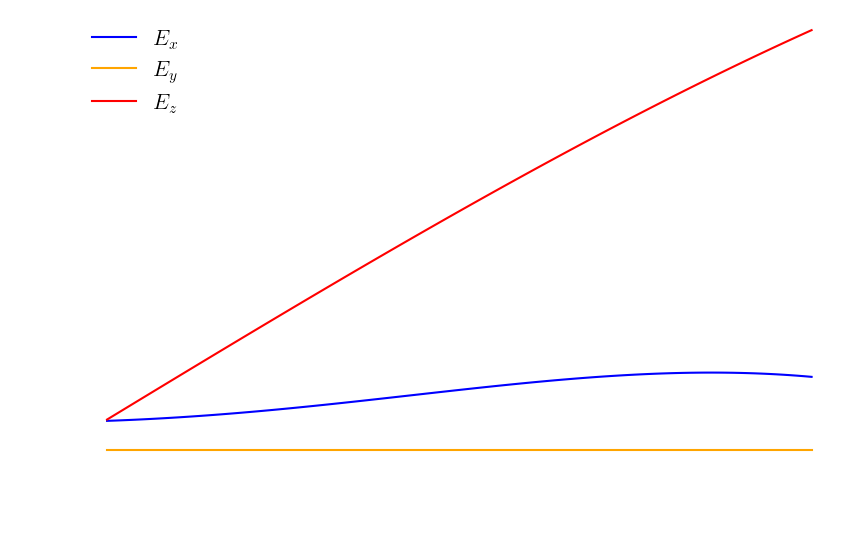

In [ ]:
l0 = 60e-9
hbar_value = 1.054571817e-34  # Planck constant over 2π, in J·s
e_constant = 1.602176634e-19  # Elementary charge magnitude, in C
e_charge = -e_constant        # Electron charge, in C
m_electron = 9.10938356e-31   # Mass of a free electron, in kg
m_si = 0.19 * m_electron  # Effective mass of electron in silicon conduction band

omega_x = hbar_value / (m_si * l0**2) / (2 * np.pi * 1e6)  # Angular frequency in rad/s

fig, ax = plt.subplots(figsize=(10, 6))
E_x_dr = np.array(E_x_dr, dtype=float)
E_y_dr = np.array(E_y_dr, dtype=float)
ax.plot(R, E_x_dr * omega_x , label='$E_x$', color='blue')
ax.plot(R, E_y_dr * omega_x, label='$E_y$', color='orange')
E_z_dr = np.array(E_z_dr, dtype=float)
ax.plot(R, E_z_dr * omega_x, label='$E_z$', color='red')
#ax.plot(R, np.sqrt(E_x_dr**2 + E_y_dr**2) * omega_x, label='E_total', color='green')
ax.set_ylabel('[MHz]')
ax.set_xlabel('$\Delta_x / l_0$ [nm]')
ax.legend()

In [ ]:
1/0

In [ ]:
omega_x * 0.00175

47.13996443566359

In [ ]:
E_y_f = E_y.subs(k0, sp.sqrt(H_conf.kc**2 + 4)).subs(kB0, gamma * sp.Abs(H_conf.kc) / 2).expand().collect(gamma).subs(gamma, 0.19).subs(symbols_bk_subs[-1])
E_y_f.subs(H_conf.kc, 1).evalf()

0

In [ ]:
E_y_f

0

In [ ]:
hbar_value = 1.054571817e-34  # Planck constant over 2π, in J·s
e_constant = 1.602176634e-19  # Elementary charge magnitude, in C
e_charge = -e_constant        # Electron charge, in C
m_electron = 9.10938356e-31   # Mass of a free electron, in kg
m_si = 0.19 * m_electron  # Effective mass of electron in silicon conduction band

In [ ]:
l0 = 60e-9
omega_x = hbar_value / (m_si * l0**2)  # Characteristic frequency in Hz

(e_constant * 0.025 /m_electron) / omega_x

0.025979473374642625

In [ ]:
E = sp.lambdify((H_conf.kc, kE), sp.sqrt(E_x_f**2 + E_y_f**2), modules='numpy')

In [ ]:
E(1, 1)

np.float64(0.0010083189988774862)

In [ ]:

kc_min, kc_max = 0.2, 1

kE_values = np.linspace(1, 10, 100)
E_vals = []
for kE_v in kE_values:
    E_vals.append([E(kc_min, kE_v), E(kc_max, kE_v)])

E_vals = np.array(E_vals)

Text(0, 0.5, '$\\sqrt{E_x^2 + E_y^2} ~/ ~2\\pi$ (MHz)')

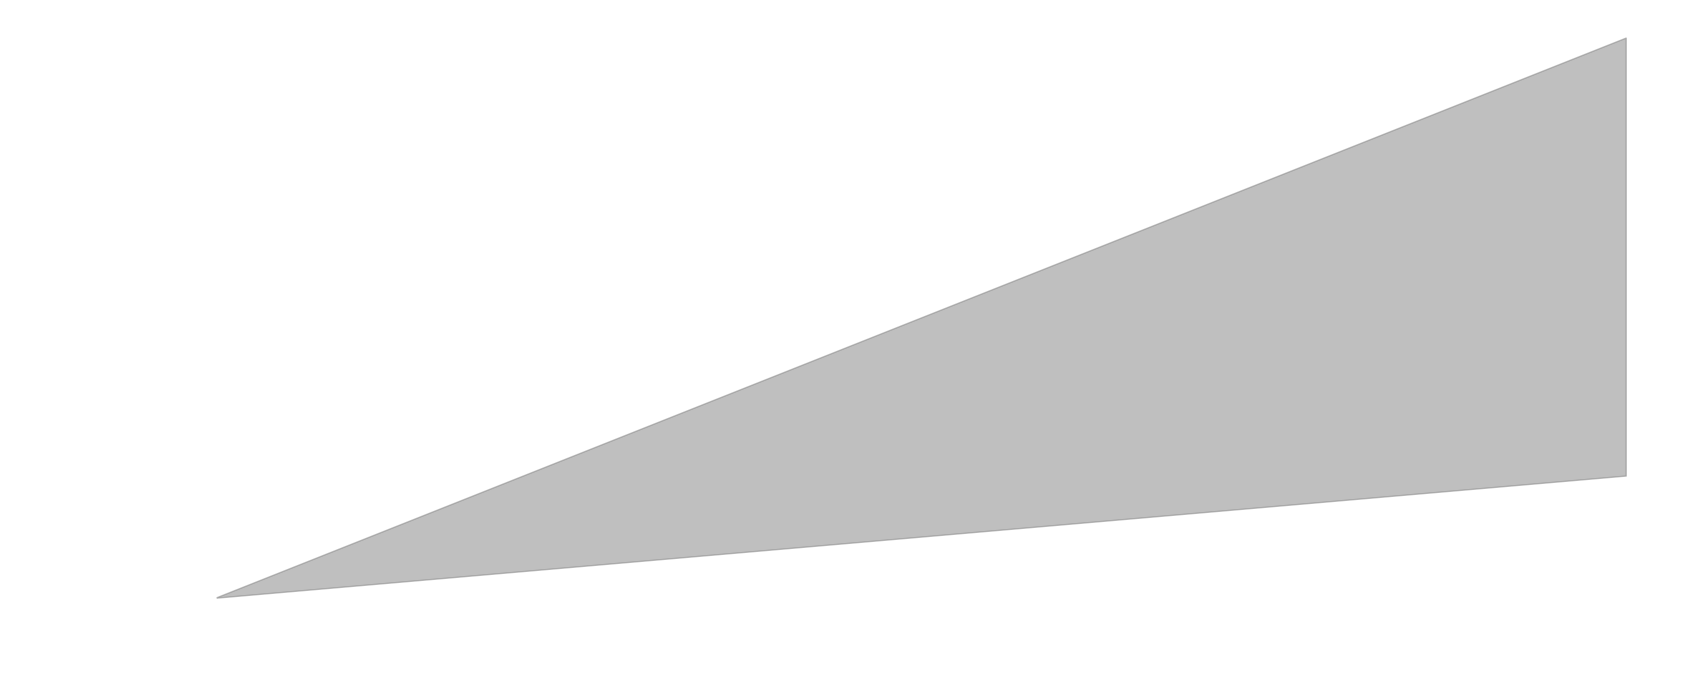

In [ ]:
fig, ax = plt.subplots( figsize=(20, 8))


E_vals_freq =  E_vals# * omega_x / (2 * np.pi * 1e6)
E_vals_freq = E_vals_freq
kE_values_ = kE_values

ax.fill_between(1/kE_values_**3, E_vals_freq[:, 0], E_vals_freq[:, 1], color='gray', alpha=0.5, label='Total Frequency Range')
ax.set_xlabel(r'$(l_0/l_E)^3$', fontsize=20)
ax.set_ylabel(r'$\sqrt{E_x^2 + E_y^2} ~/ ~2\pi$ (MHz)', fontsize=20)
#ax.set_xticklabels([f'1/{i}' for i in kE_values], fontsize=16)

Text(0, 0.5, '$\\sqrt{E_x^2 + E_y^2} ~/ ~2\\pi$ (MHz)')

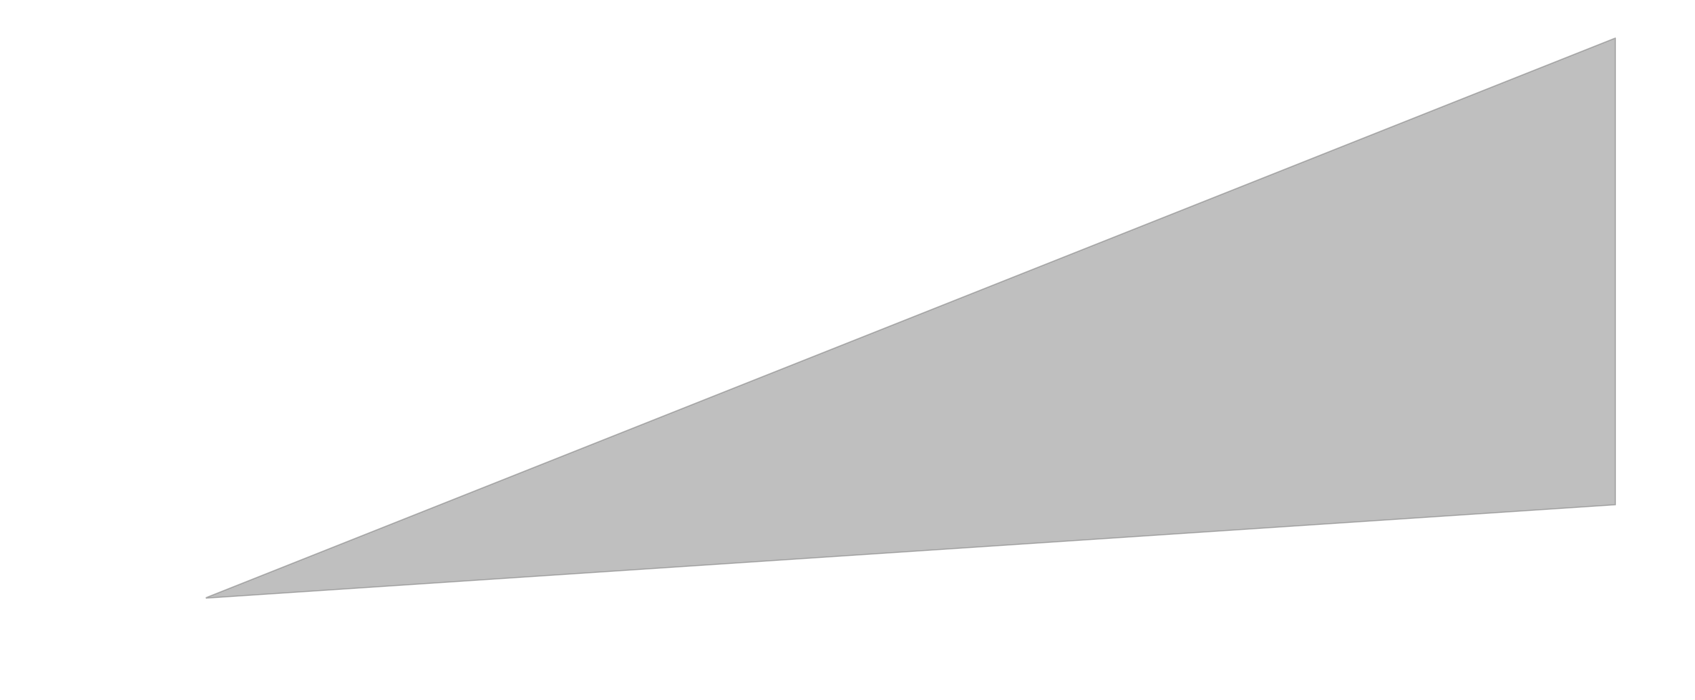

In [ ]:
fig, ax = plt.subplots( figsize=(20, 8))


E_vals_freq =  E_vals# * omega_x / (2 * np.pi * 1e6)
kE_values_ = kE_values

ax.fill_between((1/kE_values_)**3, E_vals_freq[:, 0], E_vals_freq[:, 1], color='gray', alpha=0.5, label='Total Frequency Range')
ax.set_xlabel(r'$(l_0/l_E)^3$', fontsize=20)
ax.set_ylabel(r'$\sqrt{E_x^2 + E_y^2} ~/ ~2\pi$ (MHz)', fontsize=20)
#ax.set_xticklabels([f'1/{i}' for i in kE_values], fontsize=16)